In [1]:
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType
from pyspark.shell import spark

feats = []
f = open('features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.2.0
      /_/

Using Python version 3.6.3 (default, Oct  6 2017 12:04:38)
SparkSession available as 'spark'.


In [2]:
df = spark.read.format('csv').option('sep', '\t').schema(schema).load('inputs/mini-sample.tdv.gz')

In [5]:
col_names = []
for i in range(2,len(df.columns)):
    col_names.append(df.columns[i])

In [39]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols=col_names,
                                  outputCol="features")
trans_features = vectorAssembler.transform(df)
coeff = Correlation.corr(trans_features,'features',method='pearson').collect()[0][0]

In [43]:
mtrx = coeff.toArray()

In [44]:
list_corr_pairs_coeffs = []
feature_pairs = []

for i in range(0,56):
    for j in range(0,56):
        
        if (i != j) and not(((col_names[i]+"_"+col_names[j]) in feature_pairs) or
                         ((col_names[j]+"_"+col_names[i]) in feature_pairs)):
            feature_pairs.append(col_names[i] +"_"+col_names[j])
            corr_pair_coeff = []
            corr_pair_coeff.append(col_names[i]+" , "+col_names[j])
            corr_pair_coeff.append(col_names[i])
            corr_pair_coeff.append(col_names[j])
            corr_pair_coeff.append(float(mtrx[i][j]))
            list_corr_pairs_coeffs.append(tuple(corr_pair_coeff))

In [45]:
df_corr_coeff_col_names = []
df_corr_coeff_col_names.append(StructField("Feature_Pair", StringType(), True))
df_corr_coeff_col_names.append(StructField("Feature1", StringType(), True))
df_corr_coeff_col_names.append(StructField("Feature2", StringType(), True))
df_corr_coeff_col_names.append(StructField("Pearson_Coeff", FloatType(), True))
df_corr_coeff = spark.createDataFrame(list_corr_pairs_coeffs,StructType(df_corr_coeff_col_names))

In [46]:
df_corr_coeff.where((df_corr_coeff.Feature1 == 'temperature_surface') | 
                    (df_corr_coeff.Feature2 == 'temperature_surface')).sort(df_corr_coeff.Pearson_Coeff.desc()).show()

+--------------------+--------------------+--------------------+-------------+
|        Feature_Pair|            Feature1|            Feature2|Pearson_Coeff|
+--------------------+--------------------+--------------------+-------------+
|upward_long_wave_...|upward_long_wave_...| temperature_surface|    0.9507364|
|geopotential_heig...|geopotential_heig...| temperature_surface|   0.88414276|
|downward_long_wav...|downward_long_wav...| temperature_surface|   0.83087575|
|geopotential_heig...|geopotential_heig...| temperature_surface|    0.8231031|
|temperature_surfa...| temperature_surface|precipitable_wate...|     0.708688|
|temperature_surfa...| temperature_surface|convective_availa...|    0.4671096|
|temperature_surfa...| temperature_surface|geopotential_heig...|   0.37617406|
|temperature_surfa...| temperature_surface|downward_short_wa...|   0.34058186|
|visibility_surfac...|  visibility_surface| temperature_surface|   0.28188124|
|pressure_surface ...|    pressure_surface| temperat

In [47]:
#categorical_snow_yes1_no0_surface
df_corr_coeff.where((df_corr_coeff.Feature1 == 'categorical_snow_yes1_no0_surface') | 
                    (df_corr_coeff.Feature2 == 'categorical_snow_yes1_no0_surface')
                   ).sort(df_corr_coeff.Pearson_Coeff.desc()).show()

+--------------------+--------------------+--------------------+-------------+
|        Feature_Pair|            Feature1|            Feature2|Pearson_Coeff|
+--------------------+--------------------+--------------------+-------------+
|categorical_snow_...|categorical_snow_...|  snow_cover_surface|   0.30012408|
|categorical_snow_...|categorical_snow_...|maximumcomposite_...|    0.2645679|
|categorical_snow_...|categorical_snow_...|  snow_depth_surface|    0.2408605|
|categorical_snow_...|categorical_snow_...|      albedo_surface|    0.2254173|
|water_equiv_of_ac...|water_equiv_of_ac...|categorical_snow_...|    0.2251549|
|categorical_snow_...|categorical_snow_...| pressure_tropopause|    0.2167491|
|relative_humidity...|relative_humidity...|categorical_snow_...|   0.18254393|
|categorical_snow_...|categorical_snow_...|friction_velocity...|   0.17027378|
|categorical_snow_...|categorical_snow_...|temperature_tropo...|   0.16374761|
|categorical_snow_...|categorical_snow_...|plant_can

In [48]:
df_corr_coeff.where((df_corr_coeff.Feature1 == 'categorical_snow_yes1_no0_surface') | 
                    (df_corr_coeff.Feature2 == 'categorical_snow_yes1_no0_surface')
                   ).sort(df_corr_coeff.Pearson_Coeff.asc()).show()

+--------------------+--------------------+--------------------+-------------+
|        Feature_Pair|            Feature1|            Feature2|Pearson_Coeff|
+--------------------+--------------------+--------------------+-------------+
|visibility_surfac...|  visibility_surface|categorical_snow_...|  -0.45647138|
|categorical_snow_...|categorical_snow_...|geopotential_heig...|  -0.26098943|
|categorical_snow_...|categorical_snow_...| temperature_surface|  -0.21268843|
|categorical_snow_...|categorical_snow_...|upward_long_wave_...|   -0.2037285|
|geopotential_heig...|geopotential_heig...|categorical_snow_...|  -0.19996537|
|categorical_snow_...|categorical_snow_...|precipitable_wate...|  -0.15940763|
|pressure_reduced_...|pressure_reduced_...|categorical_snow_...|  -0.13463028|
|categorical_snow_...|categorical_snow_...|mean_sea_level_pr...| -0.122622825|
|categorical_snow_...|categorical_snow_...|downward_long_wav...|  -0.11768969|
|categorical_snow_...|categorical_snow_...|    press

In [49]:
#snow_cover_surface
#snow_depth_surface
#visibility_surface

df_corr_coeff.where(((df_corr_coeff.Feature1 == 'categorical_snow_yes1_no0_surface') & 
                    (df_corr_coeff.Feature2 == 'temperature_surface')) |
                    ((df_corr_coeff.Feature2 == 'categorical_snow_yes1_no0_surface') & 
                    (df_corr_coeff.Feature1 == 'temperature_surface'))
                   ).sort(df_corr_coeff.Pearson_Coeff.asc()).show()
#temperature_surface

+--------------------+--------------------+-------------------+-------------+
|        Feature_Pair|            Feature1|           Feature2|Pearson_Coeff|
+--------------------+--------------------+-------------------+-------------+
|categorical_snow_...|categorical_snow_...|temperature_surface|  -0.21268843|
+--------------------+--------------------+-------------------+-------------+



In [50]:
df_corr_coeff.where(((df_corr_coeff.Feature1 == 'categorical_snow_yes1_no0_surface') & 
                    (df_corr_coeff.Feature2 == 'precipitable_water_entire_atmosphere')) |
                    ((df_corr_coeff.Feature2 == 'categorical_snow_yes1_no0_surface') & 
                    (df_corr_coeff.Feature1 == 'precipitable_water_entire_atmosphere'))
                   ).sort(df_corr_coeff.Pearson_Coeff.asc()).show()
#precipitable_water_entire_atmosphere

+--------------------+--------------------+--------------------+-------------+
|        Feature_Pair|            Feature1|            Feature2|Pearson_Coeff|
+--------------------+--------------------+--------------------+-------------+
|categorical_snow_...|categorical_snow_...|precipitable_wate...|  -0.15940763|
+--------------------+--------------------+--------------------+-------------+



In [51]:
#snow_cover_surface
#snow_depth_surface
#visibility_surface
#temperature_surface
#precipitable_water_entire_atmosphere

In [61]:


def prepare_data(dframe, predictors, target):
    assembler = VectorAssembler(inputCols=predictors, outputCol="features")
    output = assembler.transform(dframe)
    return output.select("features", target).withColumnRenamed(target, "label")


prepped = prepare_data(df,
    ["snow_cover_surface", 
         "snow_depth_surface", 
         "visibility_surface", 
         "temperature_surface",
         "precipitable_water_entire_atmosphere"],
    "categorical_snow_yes1_no0_surface")

prepped.show()
(trainingData, testData) = prepped.randomSplit([0.9, 0.1])

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.0,24221.20...|  0.0|
|[100.0,0.01775999...|  0.0|
|[100.0,0.05375999...|  0.0|
|[0.0,0.0,22024.20...|  0.0|
|[0.0,0.0,24222.64...|  0.0|
|[100.0,0.90279996...|  0.0|
|[0.0,0.0,24225.47...|  0.0|
|[0.0,0.0,24225.27...|  0.0|
|[0.0,0.0,24224.25...|  0.0|
|[0.0,0.0,24225.79...|  0.0|
|[0.0,0.0,21825.27...|  0.0|
|[0.0,0.0,24222.57...|  0.0|
|[100.0,0.00944000...|  0.0|
|[0.0,0.0,24225.83...|  0.0|
|[100.0,0.02439999...|  0.0|
|[0.0,0.0,24224.25...|  0.0|
|[0.0,0.0,24222.07...|  0.0|
|[0.0,0.0,24224.07...|  0.0|
|[0.0,0.0,24222.07...|  0.0|
|[0.0,0.0,24223.87...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [67]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="label", seed=42)
model = rf.fit(prepped)

In [68]:
model.featureImportances

SparseVector(5, {0: 0.075, 1: 0.0754, 2: 0.7194, 3: 0.1303})

In [72]:
predictions = model.transform(testData)
predictions.select(predictions.probability).show(n=5)

+--------------------+
|         probability|
+--------------------+
|[0.95664279808010...|
|[0.75998844918654...|
|[0.95664279808010...|
|[0.95664279808010...|
|[0.95664279808010...|
+--------------------+
only showing top 5 rows



In [74]:
predictions.select(*predictions.columns).show(n=5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,0.0,17.33257...|  0.0|[2.86992839424032...|[0.95664279808010...|       0.0|
|[0.0,0.0,17.51190...|  0.0|[2.27996534755964...|[0.75998844918654...|       0.0|
|[0.0,0.0,17.51190...|  0.0|[2.86992839424032...|[0.95664279808010...|       0.0|
|[0.0,0.0,18.01349...|  0.0|[2.86992839424032...|[0.95664279808010...|       0.0|
|[0.0,0.0,18.04895...|  0.0|[2.86992839424032...|[0.95664279808010...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [84]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)#by default considers area under roc to evaluate

0.965504638264051

In [87]:
samp_predns = predictions.sample(False, .1)
samp_predns

DataFrame[features: vector, label: float, rawPrediction: vector, probability: vector, prediction: double]

In [97]:
import numpy as np
from sklearn import metrics
predns = np.array(samp_predns.select(samp_predns.prediction).collect())

In [98]:
labels = np.array(samp_predns.select(samp_predns.label).collect())

In [99]:
fpr, tpr, thresholds = metrics.roc_curve(labels, predns)
roc_auc = metrics.auc(fpr, tpr)

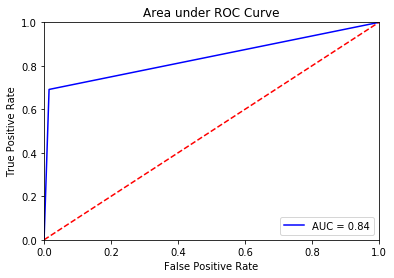

In [100]:
import matplotlib.pyplot as plt
plt.title('Area under ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()